In [1]:
# !pip install pyro-ppl 

In [1]:
import pandas as pd
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

import torch.nn as nn
import torch.nn.functional as F

import torchvision.models as models

In [3]:
df_train_data_info = pd.read_csv("D:/dataset/RFMID Training_Set/RFMiD_Training_Labels.csv")

In [2]:
classes_map = {0: 'Healthy',
 1: 'DR',
 2: 'ARMD',
 3: 'MH',
 4: 'DN',
 5: 'MYA',
 6: 'BRVO',
 7: 'TSLN',
 8: 'ERM',
 9: 'LS',
 10: 'MS',
 11: 'CSR',
 12: 'ODC',
 13: 'CRVO',
 14: 'TV',
 15: 'AH',
 16: 'ODP',
 17: 'ODE',
 18: 'ST',
 19: 'AION',
 20: 'PT',
 21: 'RT',
 22: 'RS',
 23: 'CRS',
 24: 'EDN',
 25: 'RPEC',
 26: 'MHL',
 27: 'RP',
 28: 'OTHER'}

In [5]:
training_image_folder_path = "D:/dataset/RFMID Training_Set/Training/"

In [6]:
imagedata_and_classes_dict = {
    'Image_Path': [],
    'Classes': []
}

In [7]:
for i in tqdm(range(df_train_data_info.shape[0])):#dictionary ke andar details create kar rha, image name and classes daal rha ye for loop
    row = list(df_train_data_info.iloc[i])
    image_name = str(row.pop(0))
    Disease_Risk = row.pop(0)
    if Disease_Risk==0:
        row.insert(0,1)
    else:
        row.insert(0,0)
    image_path = training_image_folder_path+image_name+".png"
    imagedata_and_classes_dict['Image_Path'].append(image_path)
    imagedata_and_classes_dict['Classes'].append(row)

100%|███████████████████████████████████████████████████████████████████████████| 1920/1920 [00:00<00:00, 86937.03it/s]


In [8]:
df_imagedata_and_classes = pd.DataFrame(imagedata_and_classes_dict)#data frame- table create ho rha hai

In [9]:
image_transform = transforms.Compose([
    transforms.Resize((512, 340)),  # Resize to a standard size (adjust as needed)
    transforms.ToTensor()
])

In [10]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['Image_Path']
        image = Image.open(img_path).convert('RGB')
        labels = torch.tensor(self.dataframe.iloc[idx]['Classes'], dtype=torch.float32)

        if self.transform:
            image = self.transform(image)

        return image, labels

In [11]:
dataset = CustomDataset(df_imagedata_and_classes, transform=image_transform)

In [12]:
Train_Data_Loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [14]:
net = models.inception_v3()

C:\Users\mishr\anaconda3\envs\ImageGeneration\Lib\site-packages\torchvision\models\inception.py:43: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(


In [15]:
net.Conv2d_1a_3x3.conv = nn.Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)

In [16]:
net.fc = nn.Linear(in_features=2048, out_features=29, bias=True)

In [17]:
# net.add_module("sigmoid", nn.Sigmoid())

In [18]:
net.aux_logits=False

In [19]:
# net

In [20]:
if torch.cuda.is_available():
    net = net.cuda()

In [20]:
import torch.optim as optim
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)

In [21]:
loss_train_list = []
acc_train_list = []

In [45]:
epochs = 5

In [23]:
import numpy as np
min_train_loss = np.inf 

In [47]:
# net.load_state_dict(torch.load("./model_weights/inception/inception_model_weights.pth"))

In [21]:
import time

In [22]:
def convert(seconds):
    return time.strftime("%H:%M:%S", time.gmtime(seconds))

In [50]:
#if torch.cuda.is_available():
print(torch.__version__)

2.3.1


In [51]:
total_time = time.time()
for e in range(epochs):
    start_time=time.time()
    train_loss = 0.0
    right_train = 0
    total_train = 0
    for data, labels in tqdm(Train_Data_Loader):
        # Transfer Data to GPU if available
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
         
        # Clear the gradients
        optimizer.zero_grad()
        net.train()
        # Forward Pass
        target = net(data)
        # Apply sigmoid activation
        sigmoid_output = torch.sigmoid(target)
        # Convert sigmoid output to binary values
        output = (sigmoid_output > 0.5).float()
        # Find the Loss
        loss = criterion(sigmoid_output,labels)
        # Calculate gradients
        loss.backward()
        # Update Weights
        optimizer.step()
        # Calculate Loss
        train_loss += loss.item()
        ftloss = train_loss / len(Train_Data_Loader)
        # Calculate accuracy
        for op1,exp1 in zip(output,labels):
            correct_predictions = 1.0 if (op1 == exp1).int().sum()==29 else 0.0
            # print(correct_predictions)
            right_train+=correct_predictions
        # correct_predictions = 1.0 if (output == labels).int().sum()==29 else 0.0
        # right_train+=correct_predictions
        total_train+=len(labels)
    ftacc = float(right_train*100/total_train)
    acc_train_list.append(ftacc)
    loss_train_list.append(ftloss)
    print('Epoch',e+1, '\tTraining Loss:',ftloss,"\t time:",convert(time.time()-start_time))
    print("Train Accuracy :",ftacc)
    if min_train_loss > train_loss:
        print("Train Loss Decreased(",min_train_loss,"--->",train_loss,") \t Saving The Model")
        min_train_loss = train_loss
        # Saving State Dict
        torch.save(net.state_dict(), 'D:/dataset/rfmid model output/inception/inception_model_weights.pth')
        torch.save(net,"D:/dataset/rfmid model output/inception/inception_model.pt")
print("total time : ",convert(time.time()-total_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [04:22<00:00,  4.38s/it]


Epoch 1 	Training Loss: 0.017267117137089373 	 time: 00:04:22
Train Accuracy : 85.05208333333333
Train Loss Decreased( inf ---> 1.0360270282253623 ) 	 Saving The Model


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [04:21<00:00,  4.36s/it]


Epoch 2 	Training Loss: 0.016275877746132515 	 time: 00:04:21
Train Accuracy : 85.46875
Train Loss Decreased( 1.0360270282253623 ---> 0.9765526647679508 ) 	 Saving The Model


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [04:21<00:00,  4.36s/it]


Epoch 3 	Training Loss: 0.017973051786733172 	 time: 00:04:21
Train Accuracy : 85.36458333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [04:20<00:00,  4.35s/it]


Epoch 4 	Training Loss: 0.016853450696604946 	 time: 00:04:20
Train Accuracy : 84.42708333333333


100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [04:21<00:00,  4.36s/it]


Epoch 5 	Training Loss: 0.01521696213943263 	 time: 00:04:21
Train Accuracy : 86.66666666666667
Train Loss Decreased( 0.9765526647679508 ---> 0.9130177283659577 ) 	 Saving The Model
total time :  00:21:49


In [54]:
# torch.save(net.state_dict(), '/home/user/research/inception/inception_model_100e_weights.pth')
# torch.save(net,"/home/user/research/inception/inception_model_100e.pt")
#min(acc_train_list)

0.4166666666666667

In [57]:
import matplotlib.pyplot as plt

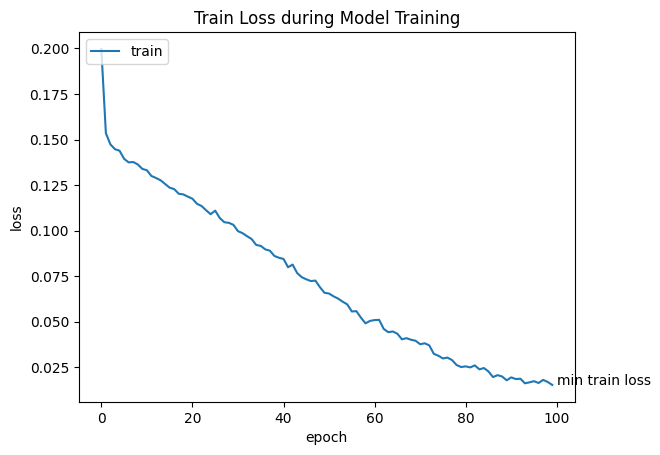

In [58]:
y_v = min(loss_train_list)
x_v = loss_train_list.index(y_v)+1
plt.plot(loss_train_list)
plt.annotate("min train loss",(x_v,y_v))
plt.title('Train Loss during Model Training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','minimum'], loc='upper left')
plt.show()

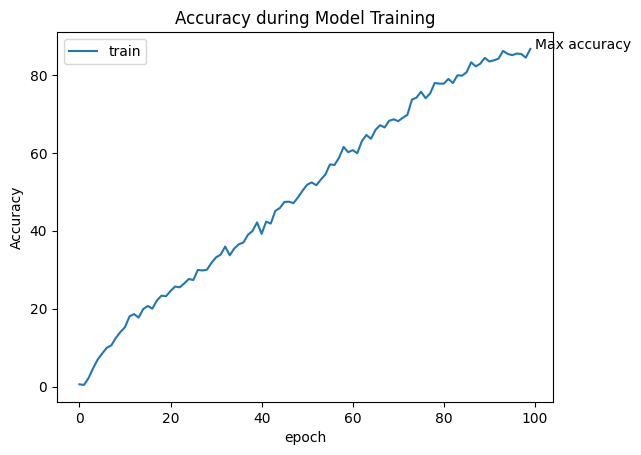

In [59]:
y_v = max(acc_train_list)
x_v = acc_train_list.index(y_v)+1
plt.plot(acc_train_list)
plt.annotate("Max accuracy",(x_v,y_v))
plt.title('Accuracy during Model Training')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train','maximum'], loc='upper left')
plt.show()

In [24]:
net.load_state_dict(torch.load("D:/dataset/rfmid model output/inception/inception_model_weights.pth"))

<All keys matched successfully>

In [4]:
df_test_data_info = pd.read_csv("D:/dataset/RFMiD Test_Set/Test_Set/RFMiD_Testing_Labels.csv")

In [5]:
df_test_data_info.head()

,ID,Disease_Risk,DR,ARMD,MH,DN,MYA,BRVO,TSLN,ERM,...,AION,PT,RT,RS,CRS,EDN,RPEC,MHL,RP,OTHER
0,1,1,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,5,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [6]:
testing_image_folder_path = "D:/dataset/RFMiD Test_Set/Test_Set/Test/"

In [7]:
imagedata_and_classes_dict = {
    'Image_Path': [],
    'Classes': []
}

In [8]:
for i in tqdm(range(df_test_data_info.shape[0])):#dictionary ke andar details create kar rha, image name and classes daal rha ye for loop
    row = list(df_test_data_info.iloc[i])
    image_name = str(row.pop(0))
    Disease_Risk = row.pop(0)
    if Disease_Risk==0:
        row.insert(0,1)
    else:
        row.insert(0,0)
    image_path = testing_image_folder_path+image_name+".png"
    imagedata_and_classes_dict['Image_Path'].append(image_path)
    imagedata_and_classes_dict['Classes'].append(row)

100%|█████████████████████████████████████████████████████████████████████████████| 640/640 [00:00<00:00, 19911.84it/s]


In [11]:
df_imagedata_and_classes = pd.DataFrame(imagedata_and_classes_dict)#data frame- table create ho rha hai

In [12]:
dataset = CustomDataset(df_imagedata_and_classes, transform=image_transform)

In [13]:
Test_Data_Loader = DataLoader(dataset, batch_size=32, shuffle=True)

In [25]:
right_train=0
total_train=0

In [26]:
for data, labels in tqdm(Test_Data_Loader):
    # Transfer Data to GPU if available
    if torch.cuda.is_available():
        data, labels = data.cuda(), labels.cuda()
    # Forward Pass
    target = net(data)
    # Apply sigmoid activation
    sigmoid_output = torch.sigmoid(target)
    # Convert sigmoid output to binary values
    output = (sigmoid_output > 0.5).float()
    # Find the Loss
   # loss = criterion(sigmoid_output,labels)
    # Calculate gradients
  #  loss.backward()
    # Update Weights
  #  optimizer.step()
    # Calculate Loss
    #train_loss += loss.item()
    #ftloss = train_loss / len(Train_Data_Loader)
    # Calculate accuracy
    for op1,exp1 in zip(output,labels):
        correct_predictions = 1.0 if (op1 == exp1).int().sum()==29 else 0.0
        # print(correct_predictions)
        right_train+=correct_predictions
    # correct_predictions = 1.0 if (output == labels).int().sum()==29 else 0.0
    # right_train+=correct_predictions
    total_train+=len(labels)
print("Test accuracy",float(right_train*100/total_train))
#acc_train_list.append(ftacc)
#loss_train_list.append(ftloss)
#print('Epoch',e+1, '\tTraining Loss:',ftloss,"\t time:",convert(time.time()-start_time))
#print("Train Accuracy :",ftacc)
#if min_train_loss > train_loss:
#    print("Train Loss Decreased(",min_train_loss,"--->",train_loss,") \t Saving The Model")
#    min_train_loss = train_loss
 #   # Saving State Dict
  #  torch.save(net.state_dict(), 'D:/dataset/rfmid model output/inception/inception_model_weights.pth')
   # torch.save(net,"D:/dataset/rfmid model output/inception/inception_model.pt")
#print("total time : ",convert(time.time()-total_time))

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:36<00:00,  7.83s/it]

Test accuracy 33.28125
